In [ ]:
import tensorflow as tf
import glob
import shutil
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense,GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from sklearn.metrics import accuracy_score 
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
base_direct='/content/drive/MyDrive/eyes'
classes = ['abiertos', 'cerrados']  

In [ ]:
for c in classes:
  img_path = os.path.join(base_direct, c) # añade la carpeta de imagenes imgpath con la vairable cl que son las clases
  images = glob.glob(img_path + '/*.jpg') # glob busca todos los archivos jpg contenidos en imgpath
  print("{}: {} Images".format(c, len(images)))# imprime la clase con la cantidad de imagenes
  n_train = int(round(len(images)*0.8)) # saca el 80% de las imagenes para train
  train, valid = images[:n_train], images[n_train:]# acomoda el 80% en train y el 20% en val

  for t in train:
    if not os.path.exists(os.path.join(base_direct, 'train', c)):# si no existe el directorio train
      os.makedirs(os.path.join(base_direct, 'train', c)) # crearlo a partir de la carpeta basedir
    shutil.copy(t, os.path.join(base_direct, 'train', c))# shutil permite hacer operaciones con archivos como copiar y mover

  for v in valid:
    if not os.path.exists(os.path.join(base_direct, 'valid', c)):
      os.makedirs(os.path.join(base_direct, 'valid', c))
    shutil.copy(v, os.path.join(base_direct, 'valid', c))

abiertos: 617 Images
cerrados: 617 Images


In [ ]:
train_direct = os.path.join(base_direct, 'train') #añade lo que hay en train a traindir
val_direct = os.path.join(base_direct, 'valid')

In [ ]:
test_direct='/content/drive/MyDrive/prueba'

In [ ]:
import keras
from keras.applications import MobileNetV2

Mobile = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224,224,3))


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in Mobile.layers:
  layer.trainable = False

In [ ]:
x=Mobile.output
x=GlobalAveragePooling2D()(x)
predicciones=Dense(2,activation='softmax')(x) #final layer with softmax activation
 

In [ ]:
model = Model(inputs = Mobile.input, outputs = predicciones)

In [ ]:
model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
#model.compile(optimizer='adam',
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#             metrics=['accuracy'])


#lr = 0.001
#optim = keras.optimizers.Adam(learning_rate=lr)

#model.compile(optimizer=optim,
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             #loss = "categorical_crossentropy",
#             metrics=['accuracy'])
#print(model.summary())

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
Image_shape = 224
batch_size = 64

train_idg = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=45,
                                width_shift_range=.15,
                                height_shift_range=.15,
                                horizontal_flip=True,
                                zoom_range=0.1
                              )
train_data = train_idg.flow_from_directory(
                                            batch_size=batch_size,
                                            directory=train_direct,
                                            shuffle=True, #deja los datos en el orden en que estan
                                            target_size=(Image_shape,Image_shape),
                                            class_mode='binary' #tipo de clasificacion que se quiere
                                          )
 
valid_idg = ImageDataGenerator(rescale=1./255) 
valid_data = valid_idg.flow_from_directory(batch_size=batch_size,
                                           directory=val_direct,
                                           target_size=(Image_shape, Image_shape),
                                           class_mode='binary') 

                                                                                                  

Found 988 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [ ]:

test_idg = ImageDataGenerator(rescale=1./255)               
test_data = test_idg.flow_from_directory(batch_size=240,
                                         directory=test_direct,
                                         target_size=(Image_shape, Image_shape),
                                         class_mode='binary')  

Found 218 images belonging to 2 classes.


In [ ]:
step_size_train=train_data.n//train_data.batch_size
history = model.fit(train_data,
                   steps_per_epoch=step_size_train,
                   validation_data = valid_data,
                   epochs=15)

target_direct = './modelo/'
if not os.path.exists(target_direct):
  os.mkdir(target_direct)
model.save('./modelo/modeloojos.h5')

Epoch 1/15
15/15 [==============================] - 49s 993ms/step - loss: 0.6185 - accuracy: 0.6564 - val_loss: 0.1610 - val_accuracy: 0.9634
Epoch 2/15
15/15 [==============================] - 14s 927ms/step - loss: 0.1696 - accuracy: 0.9519 - val_loss: 0.0977 - val_accuracy: 0.9797
Epoch 3/15
15/15 [==============================] - 14s 914ms/step - loss: 0.1045 - accuracy: 0.9711 - val_loss: 0.0666 - val_accuracy: 0.9797
Epoch 4/15
15/15 [==============================] - 14s 934ms/step - loss: 0.0845 - accuracy: 0.9681 - val_loss: 0.0610 - val_accuracy: 0.9878
Epoch 5/15
15/15 [==============================] - 14s 942ms/step - loss: 0.0774 - accuracy: 0.9734 - val_loss: 0.0499 - val_accuracy: 0.9919
Epoch 6/15
15/15 [==============================] - 14s 916ms/step - loss: 0.0715 - accuracy: 0.9850 - val_loss: 0.0445 - val_accuracy: 0.9919
Epoch 7/15
15/15 [==============================] - 14s 927ms/step - loss: 0.0540 - accuracy: 0.9839 - val_loss: 0.0407 - val_accuracy: 0.9919

In [ ]:
history.history

{'accuracy': [0.7889610528945923,
  0.9502164721488953,
  0.9675324559211731,
  0.9718614816665649,
  0.9760416746139526,
  0.9826839566230774,
  0.9740259647369385,
  0.9816017150878906,
  0.9826839566230774,
  0.9859307408332825,
  0.9837662577629089,
  0.9816017150878906,
  0.9870129823684692,
  0.9902597665786743,
  0.9870129823684692],
 'loss': [0.4528057873249054,
  0.14851191639900208,
  0.1041867658495903,
  0.08071485161781311,
  0.07375718653202057,
  0.06896433234214783,
  0.07030633836984634,
  0.06027023866772652,
  0.060615722090005875,
  0.054731328040361404,
  0.048627227544784546,
  0.05004556104540825,
  0.04846230149269104,
  0.03579312935471535,
  0.04178747534751892],
 'val_accuracy': [0.9634146094322205,
  0.9796748161315918,
  0.9796748161315918,
  0.9878048896789551,
  0.9918699264526367,
  0.9918699264526367,
  0.9918699264526367,
  0.9959349632263184,
  0.9918699264526367,
  0.9959349632263184,
  0.9959349632263184,
  0.9918699264526367,
  1.0,
  1.0,
  1.0],


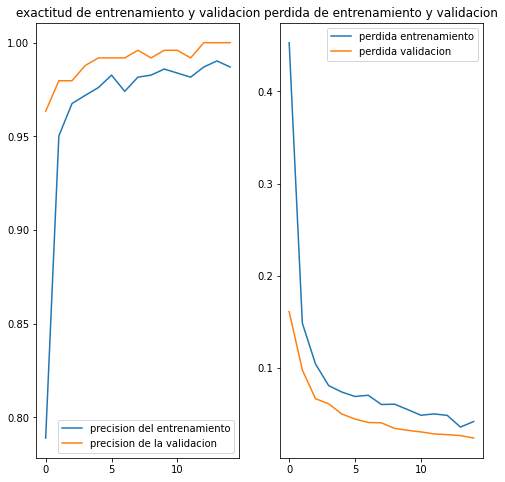

In [ ]:
precision = history.history['accuracy']
precision_val = history.history['val_accuracy']

perdida = history.history['loss']
perdida_val = history.history['val_loss']
 
epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, precision, label='precision del entrenamiento')
plt.plot(epochs_range, precision_val, label='precision de la validacion')
plt.legend(loc='lower right')
plt.title('exactitud de entrenamiento y validacion')

plt.subplot(1, 2, 2) 
plt.plot(epochs_range, perdida, label='perdida entrenamiento')
plt.plot(epochs_range, perdida_val, label='perdida validacion')
plt.legend(loc='upper right')
plt.title('perdida de entrenamiento y validacion')
plt.show()

# **PRUEBAS**


In [ ]:
model_direct = '/content/modelo/modeloojos.h5'
modelo = load_model(model_direct)

In [ ]:
data_test, label_test = test_data[0]
#predictions=modelo.predict(data_test)

In [ ]:
preds = modelo.predict(data_test)
preds = tf.squeeze(preds).numpy()
preds_iden = np.argmax(preds, axis=-1)


accuracy_score(label_test, preds_iden)


0.9954128440366973

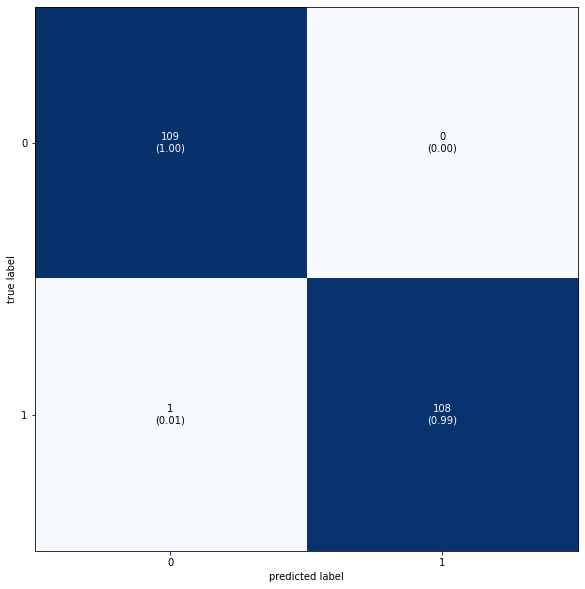

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
mat= confusion_matrix(label_test, preds_iden)
fig, ax= plot_confusion_matrix(conf_mat= mat, figsize=(10, 10), show_normed=True)